In [48]:
import os
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageDraw
import pickle
import json
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

In [20]:
class RefCOCOg(Dataset):
    """
    Args:
        dataset: a list of dictionaries containing:
        {
            'file_name': # path of the image, images will be loaded on the fly
            'caption': # referring caption
            'ann_id': # annotation ID (one per caption), taken from 'file_name'
            'bbox': # coordinates (xmin, ymin, xmax, ymax) of the bounding box
        }
    """
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [21]:
with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [22]:
def pad_image(image):
    """
    Performs bottom-right padding of the original image to 640x640 (max size of images in the dataset).
    Bottom-right padding prevents corruption of bounding boxes.

    ### Arguments
    image: a PIL.Image to transform
    """
    original_width, original_height = image.size
    padded_width, padded_height = 640, 640

    #pad_width = padded_width - original_width
    #pad_height = padded_height - original_height

    padded_image = Image.new(image.mode, (padded_width, padded_height), (0, 0, 0))
    padded_image.paste(image, (0, 0))

    return padded_image

def collate_fn(batch):
    images = [] #tensors of images
    for sample in batch:
        image = Image.open(sample["file_name"]).convert("RGB")
        image = pad_image(image=image)
        images.append(transform(image))
        #images.append(sample["file_name"])

    images = torch.stack(images, dim=0)
    
    data = {} #captions, cap_id, bbox
    for key in batch[0].keys():
        if key != "file_name":
            data[key] = [sample[key] for sample in batch]
    
    return images, data

def collate_fn2(batch):
    images, caption_tokens = zip(*batch)
    print(images)
    # Process images
    transform = transforms.Compose([
        transforms.Pad(0, fill=0),  # Replace padding_value with your desired padding
        transforms.Resize((224, 224)),  # ResNet-50 input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensors = torch.stack([transform(img) for img in images])

    # Tokenize the captions using the CLIP tokenizer
    #caption_lengths = [len(tokens) for tokens in caption_tokens]
    #max_caption_length = max(caption_lengths)
    captions = [item[1] for item in batch]
    #added_caption_tokens = [tokens + [0] * (max_caption_length - len(tokens)) for tokens in caption_tokens]
    caption_tensors = torch.tensor(captions)

    return {'images': image_tensors, 'captions': caption_tensors, 'caption_lengths': caption_lengths}

transform = transforms.Compose([
    transforms.Pad(0, fill=0),  # Replace padding_value with your desired padding
    transforms.Resize((224, 224)),  # ResNet-50 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

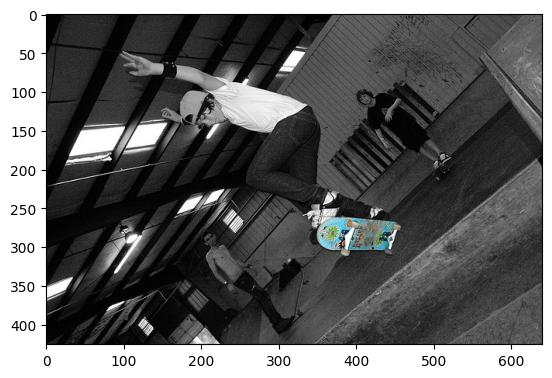

In [23]:

dataset_train = RefCOCOg(refs, annotations, split="train")
plt.imshow(Image.open(dataset_train[2]["file_name"]))
dataloader_train = DataLoader(dataset_train, batch_size=1, collate_fn=collate_fn)


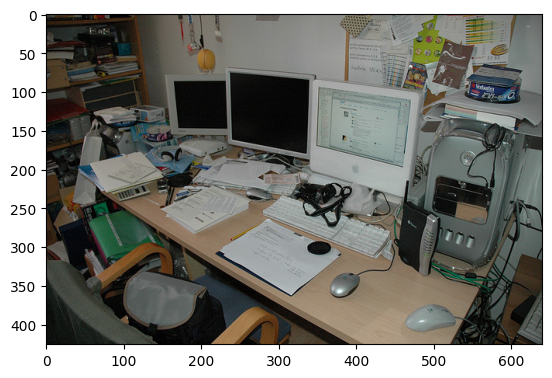

In [24]:
dataset_test = RefCOCOg(refs, annotations, split="test")
plt.imshow(Image.open(dataset_test[2]["file_name"]))
dataloader_test = DataLoader(dataset_test, batch_size=1, collate_fn=collate_fn)

# Image Encoder

In [25]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

Using cache found in /home/matea/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/matea/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/matea/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in /home/matea/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [28]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(self):
        super().__init__()
        self.model = resnet50
        for p in self.model.parameters():
            p.requires_grad = True

    def forward(self, x):
        return self.model(x)

# Text Encoder

In [31]:
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = True

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

# Projection Layer

In [33]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=256,
        dropout=0.1
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

# clip

In [34]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=1.0,
        image_embedding=2048,
        text_embedding=200,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [35]:

batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


In [40]:
import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


In [43]:


def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    print(train_loader)
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter



In [46]:

import itertools


def main():
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    train_loader = DataLoader(dataset_train, batch_size=1, collate_fn=collate_fn)
    valid_loader = DataLoader(dataset_test, batch_size=1, collate_fn=collate_fn)
    model = CLIPModel().to(device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": 1e-4},
        {"params": model.text_encoder.parameters(), "lr": 1e-5},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": 1e-3, "weight_decay": 1e-3}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=1, factor=0.8
    )
    step = "epoch"

    best_loss = float('inf')

    for epoch in range(1, 5):
        with tqdm(dataloader_test, unit="batch") as tepoch:
            for data, target in tepoch:
                print(data)
                print(target)

                tepoch.set_description(f"Epoch {epoch}")
                
                data, target = data.to(device), target.to(device) # bisogna serializzare target prima
                optimizer.zero_grad()
                output = model(data)
                predictions = output.argmax(dim=1, keepdim=True).squeeze()
                loss = F.nll_loss(output, target)
                correct = (predictions == target).sum().item()
                accuracy = correct / batch_size
                
                loss.backward()
                optimizer.step()

                tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy)

"""
    for epoch in range(5):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)
"""

'\n    for epoch in range(5):\n        print(f"Epoch: {epoch + 1}")\n        model.train()\n        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)\n        model.eval()\n        with torch.no_grad():\n            valid_loss = valid_epoch(model, valid_loader)\n\n        if valid_loss.avg < best_loss:\n            best_loss = valid_loss.avg\n            torch.save(model.state_dict(), "best.pt")\n            print("Saved Best Model!")\n\n        lr_scheduler.step(valid_loss.avg)\n'

In [ ]:
for epoch in range(1, 5):
    with tqdm(dataloader_test, unit="batch") as tepoch:
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            predictions = output.argmax(dim=1, keepdim=True).squeeze()
            loss = F.nll_loss(output, target)
            correct = (predictions == target).sum().item()
            accuracy = correct / batch_size
            
            loss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy)

In [ ]:
for a in dataloader_test:
    print(a)
    break

In [49]:
main()

  0%|          | 0/5023 [00:00<?, ?batch/s]


tensor([[[[ 1.2899,  1.2557,  1.1700,  ...,  1.4612,  1.4954,  1.4783],
          [ 1.3242,  1.3242,  1.3242,  ...,  1.4440,  1.4269,  1.4098],
          [ 1.3413,  1.3413,  1.3413,  ...,  1.3242,  1.3927,  1.3413],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[ 1.4482,  1.4307,  1.3782,  ...,  1.6232,  1.6583,  1.6408],
          [ 1.5007,  1.4832,  1.4832,  ...,  1.6057,  1.5882,  1.5707],
          [ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5532,  1.5007],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[ 1.6988,  1.6988,  1.6465,  ...,  1.8034,  1.8383,  1.8383],
          [ 1.7511,  1.7337,  

  0%|          | 0/5023 [00:00<?, ?batch/s]


tensor([[[[ 1.2899,  1.2557,  1.1700,  ...,  1.4612,  1.4954,  1.4783],
          [ 1.3242,  1.3242,  1.3242,  ...,  1.4440,  1.4269,  1.4098],
          [ 1.3413,  1.3413,  1.3413,  ...,  1.3242,  1.3927,  1.3413],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[ 1.4482,  1.4307,  1.3782,  ...,  1.6232,  1.6583,  1.6408],
          [ 1.5007,  1.4832,  1.4832,  ...,  1.6057,  1.5882,  1.5707],
          [ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5532,  1.5007],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[ 1.6988,  1.6988,  1.6465,  ...,  1.8034,  1.8383,  1.8383],
          [ 1.7511,  1.7337,  

  0%|          | 0/5023 [00:00<?, ?batch/s]


tensor([[[[ 1.2899,  1.2557,  1.1700,  ...,  1.4612,  1.4954,  1.4783],
          [ 1.3242,  1.3242,  1.3242,  ...,  1.4440,  1.4269,  1.4098],
          [ 1.3413,  1.3413,  1.3413,  ...,  1.3242,  1.3927,  1.3413],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[ 1.4482,  1.4307,  1.3782,  ...,  1.6232,  1.6583,  1.6408],
          [ 1.5007,  1.4832,  1.4832,  ...,  1.6057,  1.5882,  1.5707],
          [ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5532,  1.5007],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[ 1.6988,  1.6988,  1.6465,  ...,  1.8034,  1.8383,  1.8383],
          [ 1.7511,  1.7337,  

  0%|          | 0/5023 [00:00<?, ?batch/s]

tensor([[[[ 1.2899,  1.2557,  1.1700,  ...,  1.4612,  1.4954,  1.4783],
          [ 1.3242,  1.3242,  1.3242,  ...,  1.4440,  1.4269,  1.4098],
          [ 1.3413,  1.3413,  1.3413,  ...,  1.3242,  1.3927,  1.3413],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[ 1.4482,  1.4307,  1.3782,  ...,  1.6232,  1.6583,  1.6408],
          [ 1.5007,  1.4832,  1.4832,  ...,  1.6057,  1.5882,  1.5707],
          [ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5532,  1.5007],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[ 1.6988,  1.6988,  1.6465,  ...,  1.8034,  1.8383,  1.8383],
          [ 1.7511,  1.7337,  